In [2]:
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
from utils.hedging import run_delta_hedge_analysis
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("../data/processed/IBM_processed.csv")

data['date'] = pd.to_datetime(data['date'])
data['expiration_date'] = pd.to_datetime(data['expiration_date'])

In [9]:
data.groupby('initial_moneyness')['delta'].mean()

initial_moneyness
ATM    0.482947
ITM    0.650371
OTM    0.177067
Name: delta, dtype: float64

In [4]:
frequencies = [1, 2, 3, 7]
moneyness_levels = ['ITM', 'ATM', 'OTM']
summary = run_delta_hedge_analysis(data, frequencies)

In [5]:
aggregated_summary = (
    summary
    .groupby(['hedge_frequency', 'initial_moneyness'])['mse']
    .agg(
        mean_mse='mean',
        std_mse='std',
        n_options='count'
    )
    .reset_index()
)

aggregated_summary['initial_moneyness'] = pd.Categorical(
    aggregated_summary['initial_moneyness'],
    categories=moneyness_levels,
    ordered=True
)

aggregated_summary = aggregated_summary.sort_values([
    'hedge_frequency',
    'initial_moneyness'
])
aggregated_summary.head()

,hedge_frequency,initial_moneyness,mean_mse,std_mse,n_options
1,1,ITM,2.354049,3.675081,56
0,1,ATM,0.641567,0.692072,58
2,1,OTM,0.174791,0.279834,57
4,2,ITM,2.333572,3.581214,56
3,2,ATM,0.652911,0.669996,58


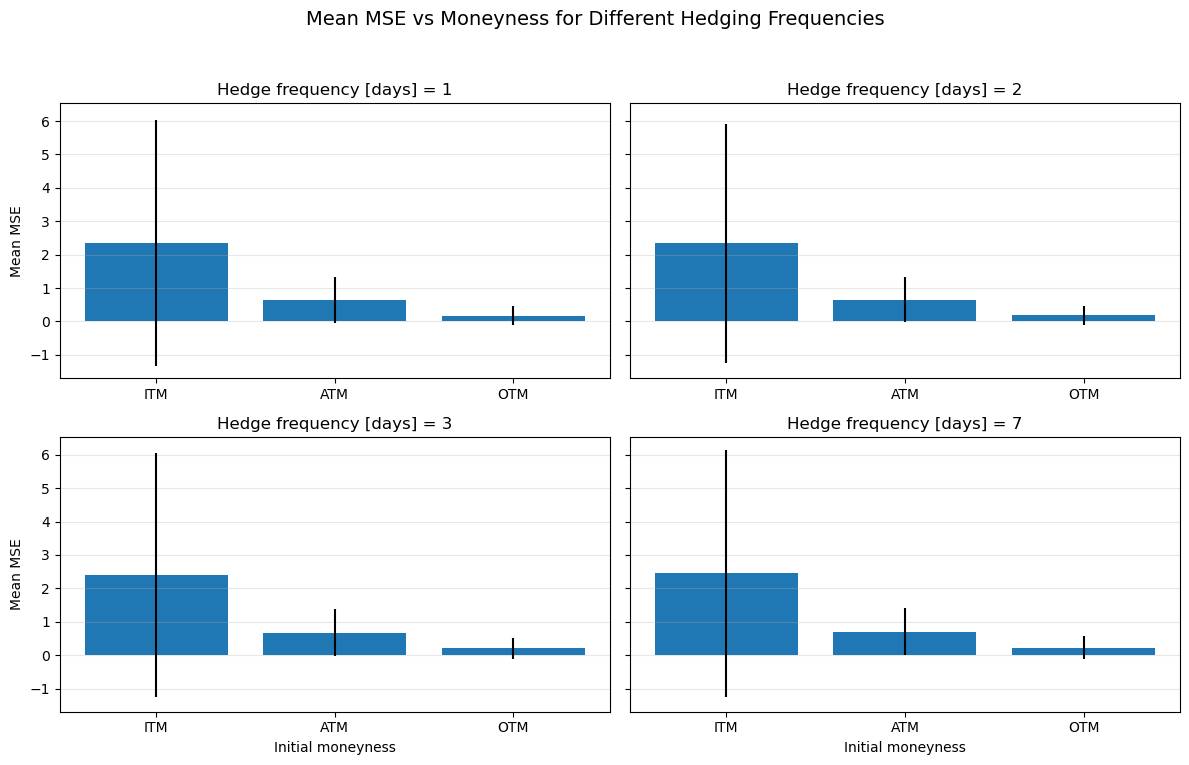

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=True)
axes = axes.ravel()

for idx, freq in enumerate(frequencies):
    ax = axes[idx]

    df = aggregated_summary[aggregated_summary['hedge_frequency'] == freq]

    x = np.arange(len(df))
    means = df['mean_mse'].values
    stds = df['std_mse'].values
    labels = df['initial_moneyness'].astype(str).tolist()

    ax.bar(x, means, yerr=stds)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    ax.set_title(f"Hedge frequency [days] = {freq}")
    ax.grid(axis="y", alpha=0.3)
    if idx % 2 == 0:
        ax.set_ylabel("Mean MSE")

for ax in axes[-2:]:
    ax.set_xlabel("Initial moneyness")

fig.suptitle("Mean MSE vs Moneyness for Different Hedging Frequencies", fontsize=14)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [10]:
aggregated_freq = (
    summary
    .groupby('hedge_frequency')['mse']
    .agg(
        mean_mse="mean",
        std_mse="std",
        n_options="count"
    )
    .reset_index()
    .sort_values("hedge_frequency")
)
aggregated_freq

,hedge_frequency,mean_mse,std_mse,n_options
0,1,1.046788,2.330228,171
1,2,1.046239,2.275111,171
2,3,1.081169,2.322553,171
3,7,1.119489,2.356160,171


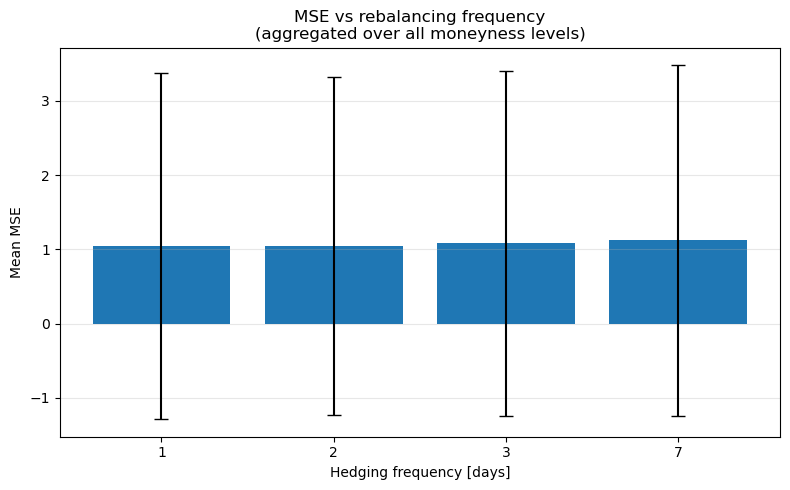

In [11]:
plt.figure(figsize=(8, 5))

x = np.arange(len(aggregated_freq))
means = aggregated_freq["mean_mse"].values
stds = aggregated_freq["std_mse"].values
labels = aggregated_freq["hedge_frequency"].astype(str).tolist()

plt.bar(x, means, yerr=stds, capsize=5)
plt.xticks(x, labels)

plt.xlabel("Hedging frequency [days]")
plt.ylabel("Mean MSE")
plt.title("MSE vs rebalancing frequency\n(aggregated over all moneyness levels)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

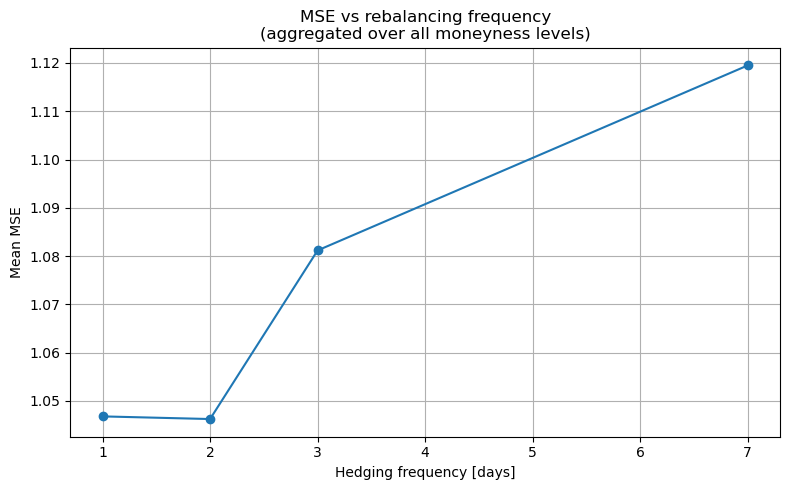

In [15]:
# for showing monotonicity
plt.figure(figsize=(8, 5))

plt.errorbar(
    aggregated_freq["hedge_frequency"],
    aggregated_freq["mean_mse"],
    fmt="o-",
    capsize=5
)

plt.xlabel("Hedging frequency [days]")
plt.ylabel("Mean MSE")
plt.title("MSE vs rebalancing frequency\n(aggregated over all moneyness levels)")
plt.grid(True)
plt.tight_layout()
plt.show()

Moneyness x Frequency interaction

In [17]:
pivot_mse = aggregated_summary.pivot(
    index='initial_moneyness',
    columns='hedge_frequency',
    values='mean_mse'
)

pivot_std = aggregated_summary.pivot(
    index='initial_moneyness',
    columns='hedge_frequency',
    values='std_mse'
)
pivot_mse


hedge_frequency,1,2,3,7
initial_moneyness,,,,
ITM,2.354049,2.333572,2.395968,2.456128
ATM,0.641567,0.652911,0.675199,0.707149
OTM,0.174791,0.181721,0.202531,0.225876


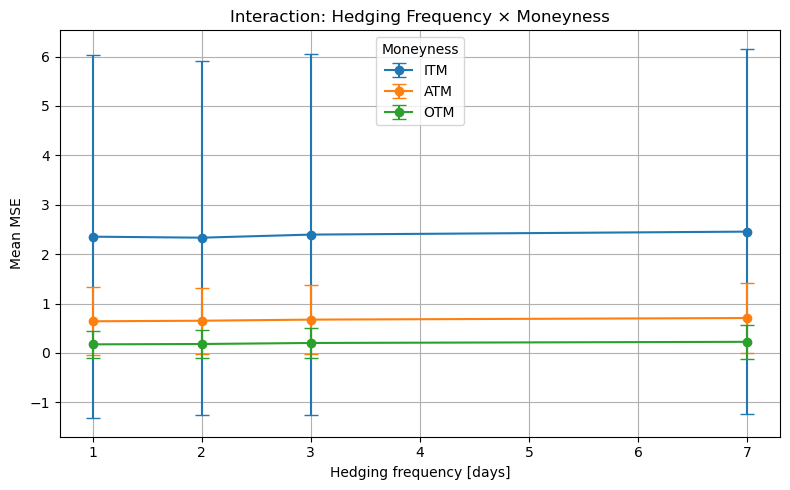

In [21]:
plt.figure(figsize=(8, 5))

for mon in moneyness_levels:
    df_mon = aggregated_summary[aggregated_summary["initial_moneyness"] == mon]
    plt.errorbar(
        df_mon["hedge_frequency"],
        df_mon["mean_mse"],
        yerr=df_mon["std_mse"],
        capsize=5,
        marker="o",
        label=mon
    )

plt.xlabel("Hedging frequency [days]")
plt.ylabel("Mean MSE")
plt.title("Interaction: Hedging Frequency × Moneyness")
plt.legend(title="Moneyness")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
summaries_freq = pd.DataFrame()
frequencies = [1, 2, 3, 7]
for(freq) in frequencies:
    s = run_delta_hedge_analysis(data = data,
                                            frequencies = freq,
                                            moneyness = 'ATM',
                                            validation_table = validation_table)
    summaries_freq = pd.concat([summaries_freq, s], ignore_index=True)
summaries_freq.head()

,expiration_date,K,initial_moneyness,hedge_frequency,errors,mse,mean_error,std_error
0,2017-01-20,155.0,ATM,1,TTM error 0 0.120548 1.205132 ...,0.361131,0.079637,0.595642
1,2017-02-17,160.0,ATM,1,TTM error 0 0.120548 1.192184 ...,0.540661,0.138012,0.722228
2,2017-03-17,165.0,ATM,1,TTM error 0 0.120548 -1.067290 ...,0.522038,0.002805,0.722516
3,2017-04-21,170.0,ATM,1,TTM error 0 0.120548 -0.446053 ...,0.111097,-0.147342,0.298977
4,2017-05-19,165.0,ATM,1,TTM error 0 0.120548 1.286721 ...,0.260866,-0.113836,0.497903


In [ ]:
aggregated_freq =(
    summaries_freq
    .groupby('hedge_frequency')
    .agg(
        mean_mse = ('mse', 'mean'),
        std_mse = ('mse', 'std'),
        median_mse = ('mse', 'median')
    )
    .reset_index()
    .sort_values('hedge_frequency')
)
aggregated_freq

,hedge_frequency,mean_mse,std_mse,median_mse
0,1,0.584467,0.674102,0.406773
1,2,0.595370,0.654218,0.415191
2,3,0.617043,0.682944,0.429958
3,7,0.647242,0.694914,0.440565


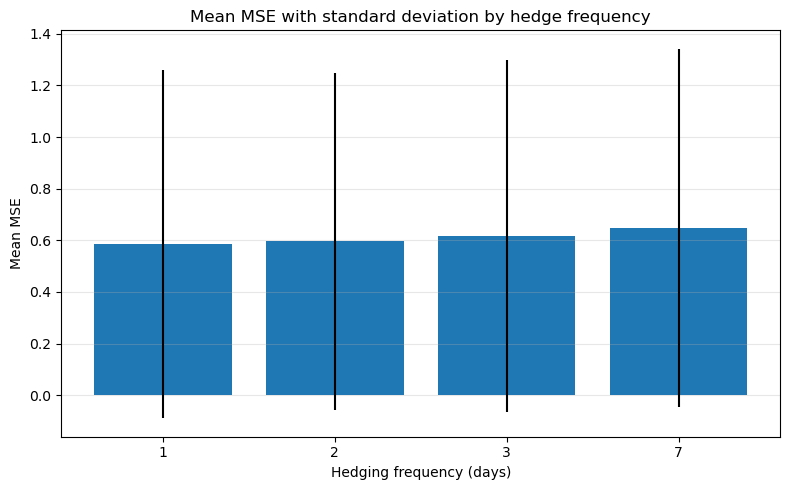

In [ ]:
plt.figure(figsize=(8, 5))

x = np.arange(len(aggregated_freq))
plt.bar(
    x,
    aggregated_freq["mean_mse"],
    yerr=aggregated_freq["std_mse"],
)

plt.xticks(x, aggregated_freq["hedge_frequency"].astype(str))
plt.xlabel("Hedging frequency (days)")
plt.ylabel("Mean MSE")
plt.title("Mean MSE with standard deviation by hedge frequency")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


In [22]:
# def collect_errors_over_time(summaries_freq: pd.DataFrame) -> pd.DataFrame:
#     rows = []
#     for _, row in summaries_freq.iterrows():
#         df = row['errors'].copy() # DataFrame with ['TTM', 'error']
#         df['hedge_frequency'] = row['hedge_frequency']
#         df['expiration_date'] = row['expiration_date']
#         df['K'] = row['K']
#         df['initial_moneyness'] = row['initial_moneyness']
#         rows.append(df)
#     return pd.concat(rows, ignore_index=True)

# errors_long = collect_errors_over_time(summaries_freq)
# errors_long = errors_long[errors_long['expiration_date'] == '2024-04-19']
# errors_long['sq_error'] = errors_long['error'] ** 2
# errors_long['days_to_maturity'] = (errors_long['TTM'] * 365).round().astype(int) 
# avg_err_time = (
#     errors_long
#     .groupby(['hedge_frequency', 'days_to_maturity'])['sq_error']
#     .mean()
#     .reset_index()
# )

In [23]:
# plt.figure(figsize=(10, 6))
# for freq in frequencies:
#     df = avg_err_time[avg_err_time['hedge_frequency'] == freq].sort_values('days_to_maturity')
#     plt.plot(
#         df['days_to_maturity'],
#         df['sq_error'],
#         marker='o',
#         label=f'Frequency: {freq} days',
#         alpha=0.8
#     )
# plt.gca().invert_xaxis()
# plt.xlabel('Days to Maturity')
# plt.ylabel('MSE per day')
# plt.title('Hedging error over time to maturity')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

In [ ]:
summaries_moneyness = pd.DataFrame()
moneynesses = ['ITM', 'ATM', 'OTM']
for m in moneynesses:
    s = run_delta_hedge_analysis(data = data,
                                            frequencies = 1,
                                            moneyness = m,
                                            validation_table = validation_table)
    summaries_moneyness = pd.concat([summaries_moneyness, s], ignore_index=True)
summaries_moneyness.head()

,expiration_date,K,initial_moneyness,hedge_frequency,errors,mse,mean_error,std_error
0,2017-01-20,140.0,ITM,1,TTM error 0 0.120548 1.186353 ...,0.440815,0.085224,0.658446
1,2017-02-17,145.0,ITM,1,TTM error 0 0.098630 -1.034937 1 ...,6.646362,0.479917,2.532990
2,2017-03-17,150.0,ITM,1,"Empty DataFrame Columns: [TTM, error] Index: []",NaN,NaN,NaN
3,2017-04-21,155.0,ITM,1,TTM error 0 0.027397 -2.202779 1 ...,3.733096,-1.435647,1.293064
4,2017-05-19,150.0,ITM,1,TTM error 0 0.082192 -3.221915 ...,0.943560,-0.384278,0.892127


In [25]:
mon_summary =(
    summaries_moneyness
    .groupby('initial_moneyness')
    .agg(
        mean_mse = ('mse', 'mean'),
        std_mse = ('mse', 'std'),
        median_mse = ('mse', 'median')
    )
    .reset_index()
    .sort_values('initial_moneyness')
)

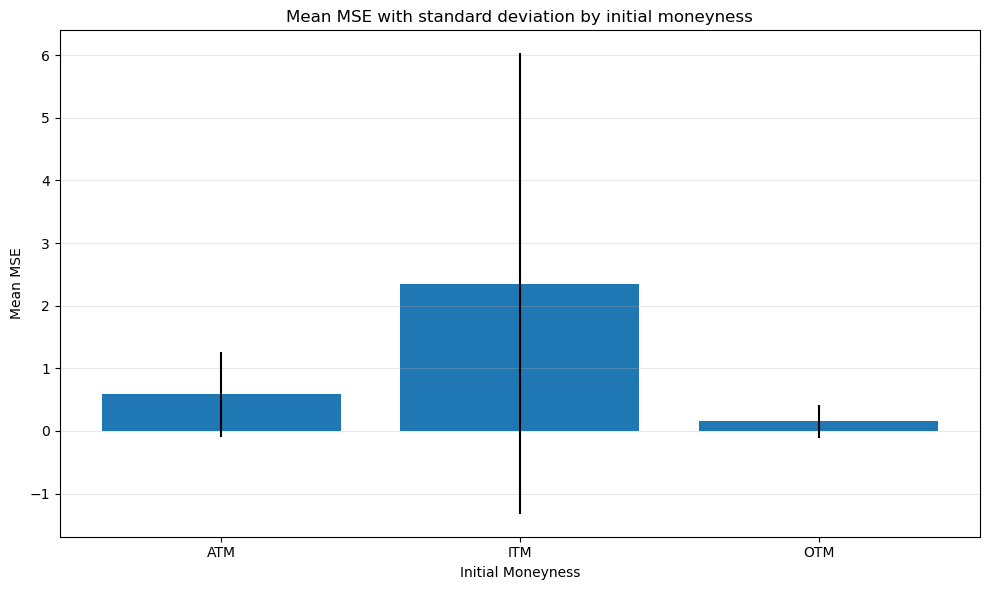

In [26]:
plt.figure(figsize=(10, 6))
plt.bar(
    mon_summary["initial_moneyness"],
    mon_summary["mean_mse"],
    yerr=mon_summary["std_mse"],
)
plt.xlabel("Initial Moneyness")
plt.ylabel("Mean MSE")
plt.title("Mean MSE with standard deviation by initial moneyness")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()